#### The goal of this is to produce a house value based on data retrieved from multiple data sources

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

## Import data

In [4]:
# Import the price paid dataset from the Land Registry API for the Chester Area

price_df = pd.read_csv('price_paid_CHESTER.csv', index_col = 0)

# Parse the dates to get year/month from datetime
price_df['datetime'] = pd.to_datetime(price_df['Transaction Date'])
price_df['year'] = price_df['datetime'].apply(lambda x: x.year)

# Concat the postcode and house number to merge on
price_df['postcode_number'] = price_df['PAON']+' '+price_df['Postcode']

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
price_df.tail()

,url,Price Paid,Transaction Date,Transaction Id,Type,About,PAON,Postcode,Street Name,datetime,year,postcode_number
183,http://landregistry.data.gov.uk/data/ppi/trans...,740000,"Thu, 30 Sep 2021",D4D42645-57A5-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,PEAR TREE COTTAGE,CH3 7JY,BARNHOUSE LANE,2021-09-30,2021,PEAR TREE COTTAGE CH3 7JY
184,http://landregistry.data.gov.uk/data/ppi/trans...,283000,"Fri, 19 Nov 2021",D4D42645-56F9-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,26,CH1 2NE,BRENNUS PLACE,2021-11-19,2021,26 CH1 2NE
185,http://landregistry.data.gov.uk/data/ppi/trans...,220000,"Fri, 08 Oct 2021",D4D42646-7DAE-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,7,CH4 0PY,BLACKTHORN CLOSE,2021-10-08,2021,7 CH4 0PY
186,http://landregistry.data.gov.uk/data/ppi/trans...,364400,"Fri, 18 Jun 2021",D4D42645-57E4-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,45,CH2 2PN,ULLSWATER CRESCENT,2021-06-18,2021,45 CH2 2PN
187,http://landregistry.data.gov.uk/data/ppi/trans...,210000,"Thu, 30 Sep 2021",D4D42645-54B4-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,12,CH3 5DL,LORD STREET,2021-09-30,2021,12 CH3 5DL


In [6]:
# Import the EPC data (Only for CH1)

epc_df = pd.read_csv('epc_CH1.csv', index_col = 0)

# Need to construct a field to merge on
# The data formatting is awful...need to use regex to clean up
# This is a quick and dirty attempt...need to study edge cases and try to improve

def clean_data(x):
    if ',' in x:
        return x.split(',')[0]
    else:
        split = x.split(' ')
        for i in split:
            try:
                num = int(split[0])
                return num
            except:
                pass
        return split[0]
        

epc_df['house/number'] = epc_df['address1'].apply(lambda x: clean_data(x))
epc_df['house/number'] = epc_df['house/number'].apply(lambda x: str(x))
epc_df['postcode_number'] = epc_df['house/number']+' '+epc_df['postcode']


epc_df.head()

,lmk-key,address1,address2,address3,postcode,building-reference-number,current-energy-rating,potential-energy-rating,current-energy-efficiency,potential-energy-efficiency,...,posttown,construction-age-band,lodgement-datetime,tenure,fixed-lighting-outlets-count,low-energy-fixed-light-count,uprn,uprn-source,house/number,postcode_number
0,691200819902019042819015293112888,"7, Tennyson Walk",Blacon,NaN,CH1 5UN,2919111968,A,A,92,94,...,CHESTER,England and Wales: 1967-1975,2019-04-28 19:01:52,owner-occupied,NaN,NaN,2.000008e+11,Address Matched,7,7 CH1 5UN
1,692126352812017030820535191030696,"2, Meadowcroft",Saughall,NaN,CH1 6EU,6688211968,A,A,93,96,...,CHESTER,England and Wales: 1976-1982,2017-03-08 20:53:51,owner-occupied,NaN,NaN,1.000100e+11,Address Matched,2,2 CH1 6EU
2,288745278612009052014570601910069,Apartment 123 The Quarter,Egerton Street,NaN,CH1 3NR,916812668,A,A,94,96,...,CHESTER,England and Wales: 2003-2006,2009-05-20 14:57:06,owner-occupied,NaN,NaN,1.000008e+10,Address Matched,Apartment,Apartment CH1 3NR
3,b0cde21277dd10b73f076fadd46c051db5c5d84e5a87f0...,3 Tillage Close,Backford,NaN,CH1 6PZ,10001513495,B,B,84,84,...,CHESTER,2020,2021-09-30 14:45:38,Not defined - use in the case of a new dwellin...,10.0,NaN,1.009468e+10,Energy Assessor,3,3 CH1 6PZ
4,dd374d1e4a1b52185a2b1031e55f74d4cef4770537eb55...,Eden House,Well Lane,Mollington,CH1 6LD,10001642164,B,B,87,91,...,Chester,2021,2021-09-30 10:34:32,Not defined - use in the case of a new dwellin...,100.0,NaN,NaN,NaN,Eden,Eden CH1 6LD


In [7]:
# Merge the datasets

merged_df = pd.merge(price_df, epc_df, how = 'left', left_on = 'postcode_number', right_on = 'postcode_number')

# Delete records where there isn't a UPRN

merged_df.dropna(subset = ['uprn'], inplace = True)

/tmp/ipykernel_3866/777847877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['Price Paid'] = df_21['Price Paid'].apply(lambda x: int(x))


<AxesSubplot:ylabel='Density'>

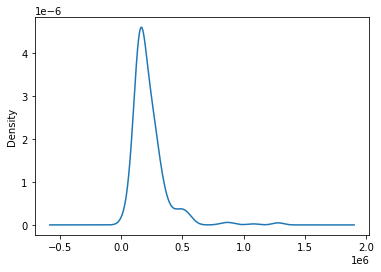

In [8]:
### Examine most recent year - 2021 in this instance
# Change to examine year in date time rather than int val?

df_21 = merged_df[merged_df['year']==2021]

df_21['Price Paid'] = df_21['Price Paid'].apply(lambda x: int(x))

df_21['Price Paid'].plot.kde()

In [9]:
df_21['Price Paid'].describe()

count    3.680000e+02
mean     2.282449e+05
std      1.467426e+05
min      4.000000e+04
25%      1.497500e+05
50%      1.850000e+05
75%      2.700000e+05
max      1.280000e+06
Name: Price Paid, dtype: float64

In [10]:
## Quick way to see all the columns available
# for i in df_21.columns:
#     print(i)

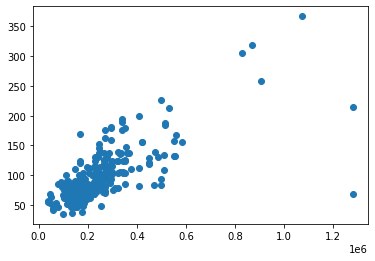

In [11]:
plt.scatter(df_21['Price Paid'],df_21['total-floor-area'])
plt.show()

In [23]:
### Build Model

# First test based on the relationship between price paid and area

# Training data
X = np.array(list(zip(df_21.index,df_21['total-floor-area'])))

# Target data
y = np.array(list(zip(df_21.index, df_21['Price Paid'].values)))

model = LinearRegression().fit(X,y)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
## Need to engineer some new features

# Is there a way to get long/lat? If so...

# 1. Distance to railstation
# Get coordinates for railstation in CRS 27700
math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
# 2. Distance to town centre